In [ ]:
import matplotlib.pyplot as plt
from numpy import random as R
import numpy as np

# Normalizes each row of M to have norm 1
def norm_rows(M):
    return M / np.sqrt(np.sum(M * M, axis=1, keepdims=True))

def plot_sample(X, C, bb=[], ms=10, colors='bgrcmk'):
    if X.shape[1] > 2: 
        _, v = np.linalg.eig(X.T @ X)
        v = np.array(v, dtype=np.float32)
        # v[:,0:2] is the two most significant eigenvectors
        # X @ v[:,0:2] projects X onto these two eigenvectors
        Xplot = X @ v[:,0:2]
    else:
        Xplot = X
    from itertools import cycle
    k = int(C.max()) + 1
    fig = plt.figure('Sample (Projected)', figsize=(8,8))
    if bb != []:
        plt.xlim(bb[0]), plt.ylim(bb[1])
    cycol = cycle(colors)
    for i in range(k):
        ind = C == i
        col = next(cycol)
        plt.scatter(Xplot[ind,0], Xplot[ind,1], s=ms, c=col)

In [ ]:
def generate_mixture_params(k, d, iso=True, sep=1):
    Pi = np.exp(R.randn(k) / np.sqrt(k))
    Pi = Pi / sum(Pi)
    Mu = sep * norm_rows(R.randn(k, d))
    Si  = [] 
    for i in range(k):
        A = R.randn(d, 3 * d) 
        A = A @ A.T
        A = np.linalg.det(A) ** (-1/k) * A # To prevent spikiness
        if iso:
            A = np.diag(np.diag(A))
        Si.append(A)
    Si = np.array(Si)
    return (Pi, Mu, Si)

In [ ]:
def sample_from_mog(mog, n):
    Pi, Mu, Si = mog
    k, d = Mu.shape
    s = R.multinomial(n, Pi)
    X = np.zeros((n, d))
    C = np.zeros(n)
    po = 0
    for i in range(k):
        pn = po + s[i]
        X[po:pn,:] = R.multivariate_normal(Mu[i], Si[i], s[i])
        C[po:pn] = i
        po = pn
    return C, X

In [ ]:
import torch
import torch.nn.functional as F

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def cnorm2(M):
    return torch.norm(M, dim = 0)**2

In [ ]:
def init(X, k):
    n = X.shape[0]
    indices = torch.randperm(n)[:k]
    return X[indices]

In [ ]:
def l2associate(X, W):
    xn = cnorm2(X.T).reshape(X.shape[0],1)
    wn = cnorm2(W.T).reshape(W.shape[0],1)
    
    x_repeat = xn.repeat(1,W.shape[0])
    w_repeat = wn.T.repeat(X.shape[0],1)
    sq_dists = x_repeat + w_repeat - 2*(X @ W.T)
    
    min_dists, assoc = torch.min(sq_dists, dim = 1)
    
    return (min_dists.mean()).item(), assoc.view(-1)

In [ ]:
def l2estimate(X, k, assoc):
    W = torch.zeros(k, X.shape[1])
    #print(X.shape)
    for i in range(k):
      mask = (assoc == i).nonzero().view(-1)
      if mask.shape[0] != 0:
        W[i] = torch.mean(X[mask], dim = 0)
    return W

In [ ]:
def kMeans(X, k, max_epochs=20, eps=1e-3):
    loss = []
    W = init(X,k)
    for itr in range(max_epochs):
      dist, assoc = l2associate(X, W)
      loss.append(dist)
      W = l2estimate(X, k, assoc)
    return W, loss

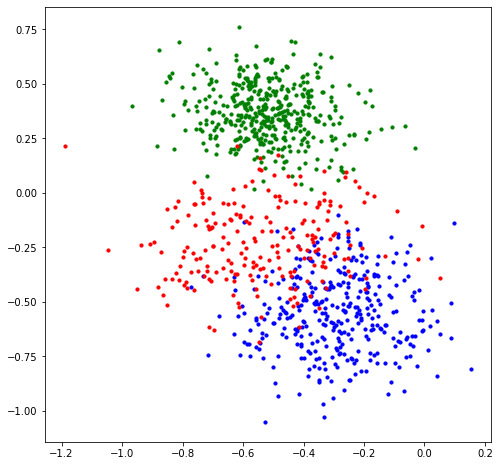

In [ ]:
torch.manual_seed(4)
np.random.seed(4)

n, d, k = 1000, 7, 3
mog = generate_mixture_params(k, d, iso=False, sep=np.sqrt(k/d))
C, Xt = sample_from_mog(mog, n)  # Xt and C are numpy arrays
plot_sample(Xt, C)
X = torch.from_numpy(Xt).float().to(dev)  # make X a PyTorch array

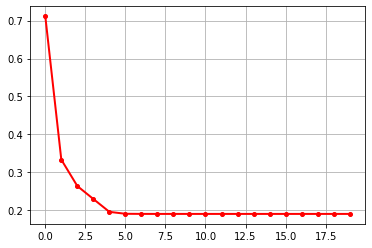

In [ ]:
W, loss = kMeans(X, k)

plt.plot(loss, lw=2, ms=4, c='r', marker='o')
plt.grid()
_ = plt.axis('tight')

In [ ]:
n, d, k = 10000, 20, 5

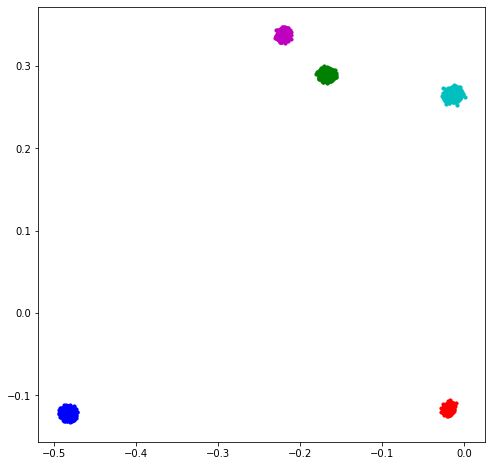

In [ ]:
mog = generate_mixture_params(k, d, iso=False, sep=np.sqrt(k/d))
C, Xt = sample_from_mog(mog, n)
plot_sample(Xt, C)
X = torch.from_numpy(Xt).float().to(dev)

In [ ]:
W1, loss = kMeans(X, 1)
print('[{:-2}/{:-2}] {:7.0}'.format(1, 1, loss[-1]))
bl = loss[-1] * np.ones(3*k)
nz = np.zeros(3*k, dtype=int)
for test_k in np.arange(2, 2*k+1):
    for e in range(100):
        W, loss = kMeans(X, test_k)
        if loss[-1] < bl[test_k]:
            bl[test_k] = loss[-1]
            nz[test_k] = (cnorm2(W.T) != 0).sum().item()
    print('[{:-2}/{:-2}] {:-7.4}'.format(nz[test_k], test_k, bl[test_k].round(4)))

[ 1/ 1]     0.2
[ 2/ 2]  0.1059
[ 3/ 3]  0.0679
[ 4/ 4]  0.0303
[ 5/ 5]  0.0002
[ 6/ 6]  0.0002
[ 7/ 7]  0.0002
[ 8/ 8]  0.0002
[ 9/ 9]  0.0002
[10/10]  0.0002


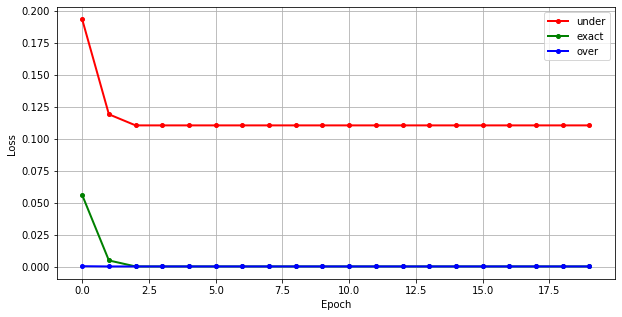

In [ ]:
Wu, loss_u = kMeans(X, round(k/2))  # under (too few clusters)
We, loss_e = kMeans(X, k)  # exact (the right number of clusters)
Wo, loss_o = kMeans(X, 2 * k)  # over (too many clusters)

plt.figure('Loss (per Epoch)', figsize=(10,5))
plt.plot(loss_u, lw=2, ms=4, c='r', marker='o')
plt.plot(loss_e, lw=2, ms=4, c='g', marker='o')
plt.plot(loss_o, lw=2, ms=4, c='b', marker='o')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(('under', 'exact', 'over')), plt.grid()
_ = plt.axis('tight')

# Compressing an Image with Clustering

In lecture, we compressed an image using clustering, by clustering each separate pixel. However, what about clustering patches of an image instead of individual pixels? In this section, we explore how this can work.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


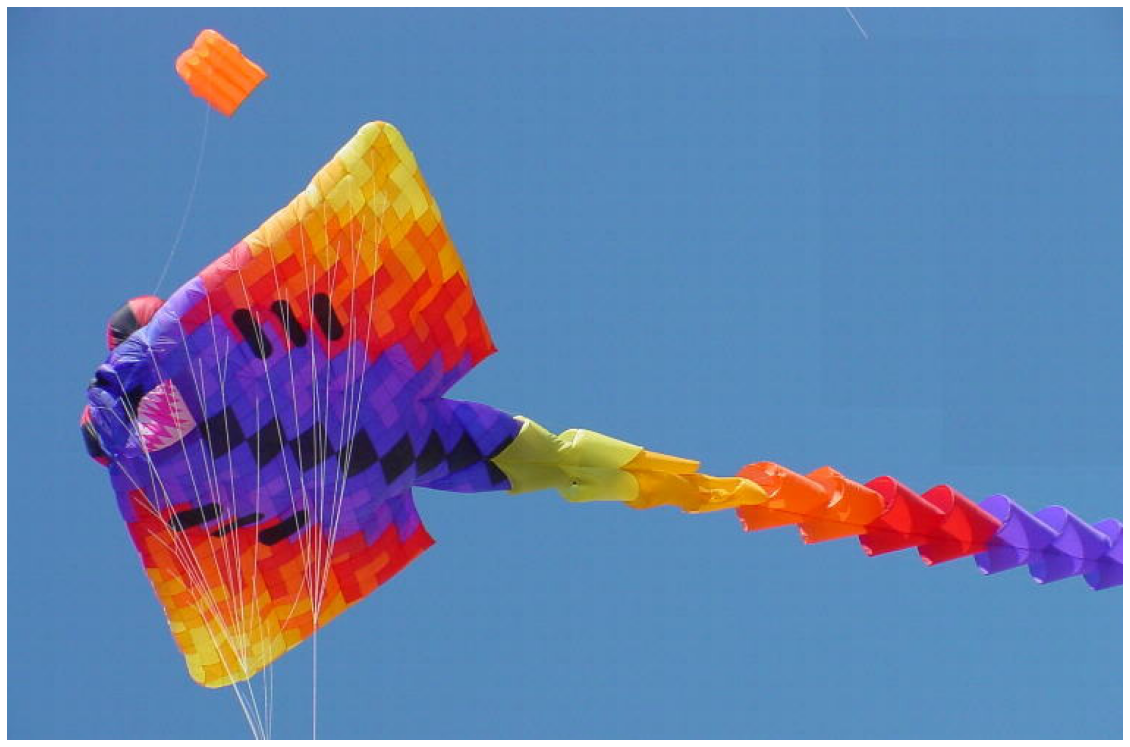

In [ ]:
import urllib
from matplotlib.image import imread
from google.colab import drive

# make sure the image is in the same folder as your notebook, or adjust the path to point to the right image
image = plt.imread('../kite3.jpeg') # you can cluster a different image by changing the file path here
plt.figure(num=None, figsize=(20, 30))
plt.imshow(image)
_ = plt.axis('off')

image = np.float32(image)
nx, ny = image.shape[0:2]

In [ ]:
# extracted patches are of size ps x ps
ps = 5
pad = 4 * [ps // 2]  # pad the image by ps//2 on all 4 sides

# Separate channels and pad each color channel
Xr = F.pad(torch.tensor(image[:,:,0]), pad)
Xg = F.pad(torch.tensor(image[:,:,1]), pad)
Xb = F.pad(torch.tensor(image[:,:,2]), pad)

# Create patches, flatten, and pack into a single matrix
Pr = Xr.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
Pg = Xg.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
Pb = Xb.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
V = torch.cat([Pr, Pg, Pb], dim=1).to(dev)

In [ ]:
num_clusters = 256
b_loss = 1e10

assert V.shape[1] == 3*ps*ps

for e in range(3):
    W, pl = kMeans(V, num_clusters)
    if pl[-1] < b_loss:
        b_loss, b_W, b_pl = pl[-1], W, pl
    
    nz = (cnorm2(W.T) != 0).sum().item()
    
    avg_patch_loss = pl[-1] / (3 * ps * ps)
    print('[{:-2}/{:-2}] {:-7.4f}'.format(nz, num_clusters, avg_patch_loss))

W, pl = b_W, b_pl

[250/256] 100.1673
[252/256] 106.3437
[248/256] 97.1709


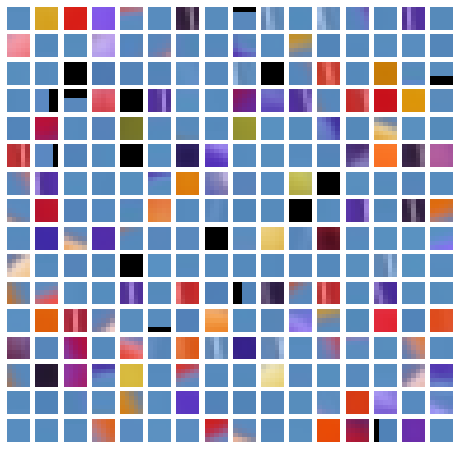

In [ ]:
patches = (W.reshape(num_clusters, 3, ps, ps)).numpy()
patches = np.moveaxis(patches, 1, 3).round().astype(int)
xyp = int(np.sqrt(num_clusters))
plt.figure(figsize=(8, 8))
for idx in range(num_clusters):
    plt.subplot(xyp, xyp, idx + 1)
    plt.imshow(patches[idx,:,:,:])
    plt.axis('off')

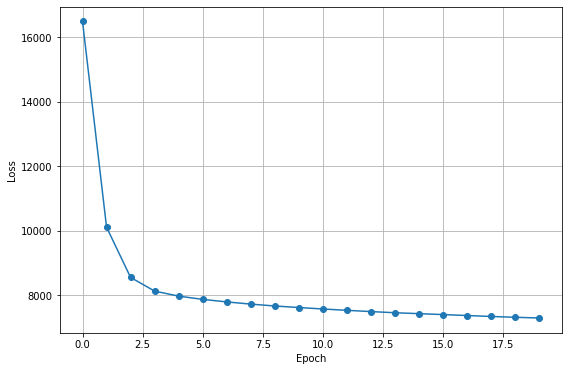

In [ ]:
plt.figure(figsize=(9, 6)), plt.plot(pl, marker='o')
_ = plt.axis('tight'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.grid()

In [ ]:
_, inds = l2associate(V, W)
Vcmpct = W[inds,:].reshape(-1, 3, ps, ps)

In [ ]:
nc0 = Vcmpct[:,0,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc0 = F.fold(nc0, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc1 = Vcmpct[:,1,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc1 = F.fold(nc1, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc2 = Vcmpct[:,2,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc2 = F.fold(nc2, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

new_image = (np.stack((nc0, nc1, nc2), axis=2) / (ps * ps)).round().astype(int)

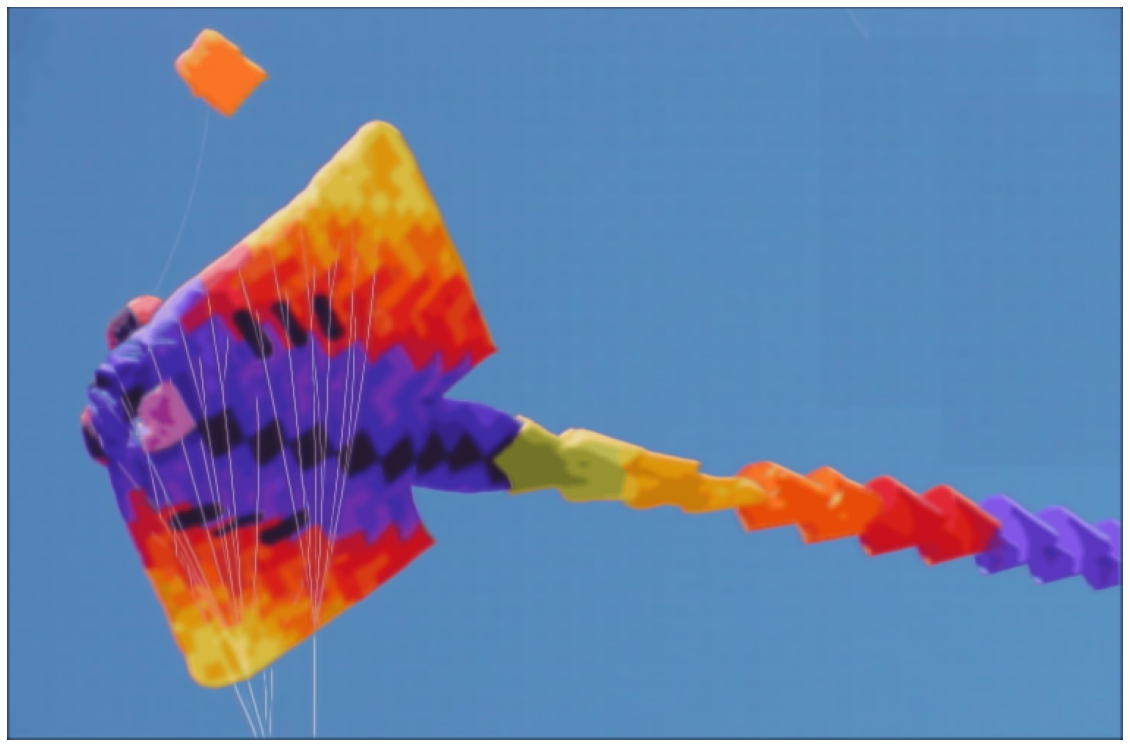

In [ ]:
plt.figure(num=None, figsize=(20, 30))
plt.imshow(new_image)
_ = plt.axis('off')

In [ ]:
num_clusters = 9
b_loss = 1e10
assert V.shape[1] == 3*ps*ps

for e in range(3):
    W, pl = kMeans(V, num_clusters)
    if pl[-1] < b_loss:
        b_loss, b_W, b_pl = pl[-1], W, pl
    
    nz = (cnorm2(W.T) != 0).sum().item()
    
    # avg_patch_loss stands for the loss when averaged over all pixels in a patch
    avg_patch_loss = pl[-1] / (3 * ps * ps)
    print('[{:-2}/{:-2}] {:-7.4f}'.format(nz, num_clusters, avg_patch_loss))

# b stands for best, such as best_W or best_patch_loss
W, pl = b_W, b_pl

[ 9/ 9] 300.9708
[ 9/ 9] 327.6758
[ 9/ 9] 308.5870


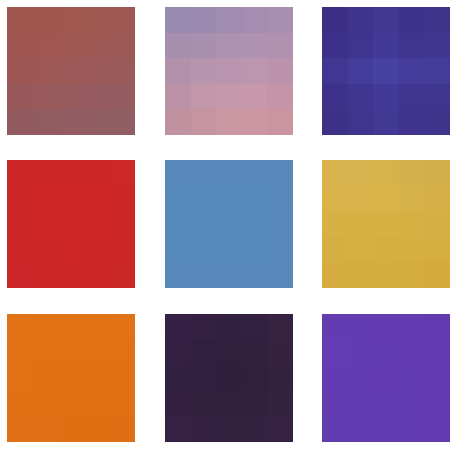

In [ ]:
patches = (W.reshape(num_clusters, 3, ps, ps)).numpy()
patches = np.moveaxis(patches, 1, 3).round().astype(int)
xyp = int(np.sqrt(num_clusters))
plt.figure(figsize=(8, 8))
for idx in range(num_clusters):
    plt.subplot(xyp, xyp, idx + 1)
    plt.imshow(patches[idx,:,:,:])
    plt.axis('off')

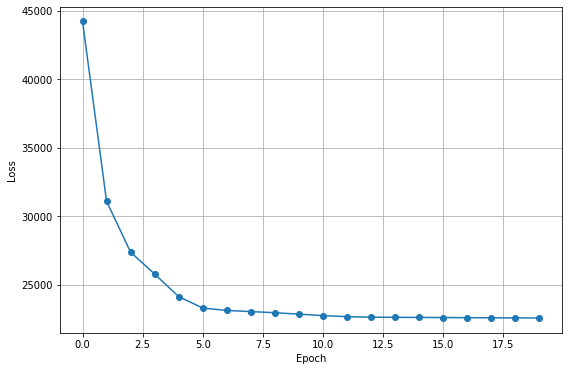

In [ ]:
plt.figure(figsize=(9, 6)), plt.plot(pl, marker='o')
_ = plt.axis('tight'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.grid()

In [ ]:
_, inds = l2associate(V, W)
Vcmpct = W[inds,:].reshape(-1, 3, ps, ps)

In [ ]:
nc0 = Vcmpct[:,0,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc0 = F.fold(nc0, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc1 = Vcmpct[:,1,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc1 = F.fold(nc1, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc2 = Vcmpct[:,2,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc2 = F.fold(nc2, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

new_image = (np.stack((nc0, nc1, nc2), axis=2) / (ps * ps)).round().astype(int)

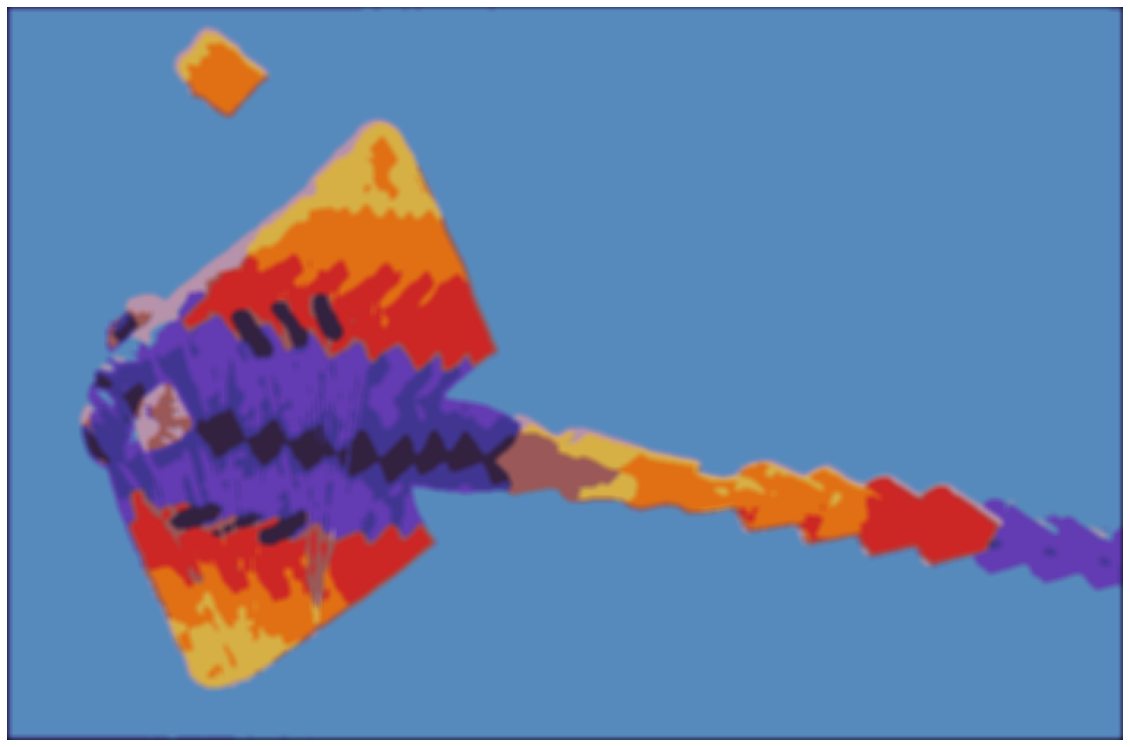

In [ ]:
plt.figure(num=None, figsize=(20, 30))
plt.imshow(new_image)
_ = plt.axis('off')